## Predicting House prices using linear regression

## Dataset can be found at
https://www.kaggle.com/c/house-prices-advanced-regression-techniques

In [1]:
#First we import the necessary libraries
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

#to check skewness of data
from scipy.stats import skew
from scipy.stats.stats import pearsonr

#to avoid printing out pandas values with too many digits
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
#get data out
house_train = pd.read_csv('../datasets/house_prices/train.csv')
house_test  = pd.read_csv('../datasets/house_prices/test.csv')
print(house_train.shape, house_test.shape)

((1460, 81), (1459, 80))


Ok. As we can see there is the same quantity of train and test data. Test data misses the SalePrice column

Predicting expensive houses price could generate bigger errors than on cheaper ones so we better use the log1p function
in order to avoid that.
Also this could help reducing data skewness.

In [3]:
skew(house_train.SalePrice)

1.880940746034036

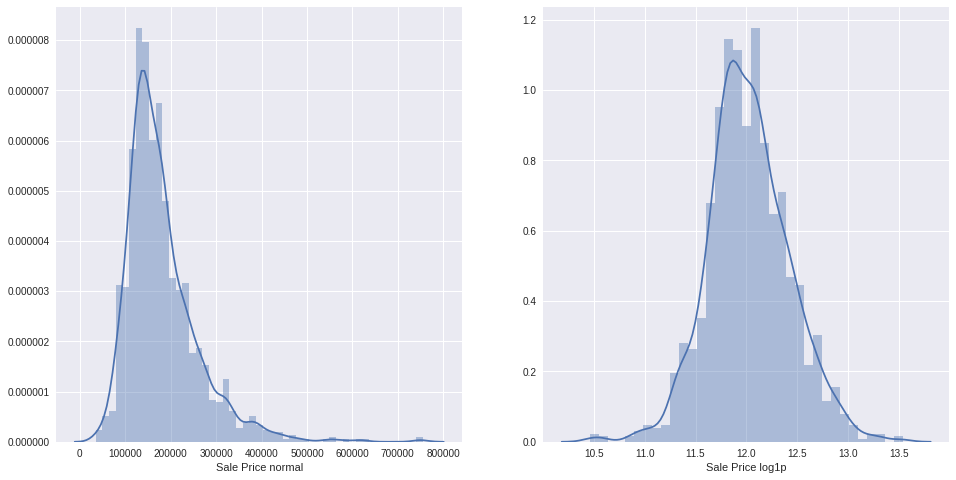

In [4]:
#to show what we just said let's plot the distribution of sale prices
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(16,8))
sns.distplot(house_train.SalePrice, axlabel='Sale Price normal', ax=ax1); #semicolon is to avoid printing plots location 
sns.distplot(np.log1p(house_train.SalePrice), axlabel='Sale Price log1p', ax=ax2);


In [5]:
#according to the plots we log sale prices
house_train.SalePrice = np.log1p(house_train.SalePrice)

In [6]:
#check number of numeric and categorical features
numeric_feats = house_train.dtypes[house_train.dtypes != 'object'].count()
categor_feats = house_train.dtypes[house_train.dtypes == 'object'].count()
numeric_feats,categor_feats

(38, 43)

In [7]:
#first we try a simple get_dummies to transform categorical features into numeric and see how it goes
all_data = pd.concat([house_train.loc[:,'MSSubClass':'SaleCondition'], #take SalePrice and Id out
                     house_test.loc[:,'MSSubClass':'SaleCondition']])
print(all_data.shape)
dummies = pd.get_dummies(all_data)

(2919, 79)


In [8]:
#check columns with NaN
nan_columns = dummies.columns[dummies.isnull().any()].tolist()
nan_columns

['LotFrontage',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea']

In [9]:
#check how many NaN: if too many we just drop the column
dummies[nan_columns].isnull().sum()

LotFrontage     486
MasVnrArea       23
BsmtFinSF1        1
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
BsmtFullBath      2
BsmtHalfBath      2
GarageYrBlt     159
GarageCars        1
GarageArea        1
dtype: int64

In [10]:
#Ok not so many Nan, we can just fill them out. For LotFrontage we take the mean
dummies.LotFrontage = dummies.LotFrontage.fillna(dummies.LotFrontage.mean())

#for MasVrnArea we do the same
dummies.MasVnrArea = dummies.MasVnrArea.fillna(dummies.MasVnrArea.mean())

#for GarageYrBlt we take the mode instead
dummies.GarageYrBlt = dummies.GarageYrBlt.fillna(dummies.GarageYrBlt.mode()[0])

#the remaining only have 1 or 2 NaN so it really does not matter how we fill them. We choose the mean
cols = ['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath','GarageCars','GarageArea']
dummies[cols] = dummies[cols].fillna(dummies[cols].mean())

In [11]:
#double check we have no more Nan values: output should be 0
dummies.isnull().sum().sum()

0

In [12]:
#let's now split back train and test set and start predicting prices
X_train = dummies[:house_train.shape[0]]
X_test  = dummies[house_train.shape[0]:]
y_train = house_train.SalePrice
all_train = pd.concat([X_train,y_train], axis=1)#this is needed to create validation set

We are going to use those sets all over the notebook with different models

In [13]:
#double check shapes
X_train.shape,X_test.shape,y_train.shape

((1460, 288), (1459, 288), (1460,))

## Models

We start using a simple **linear Regression** model and evaluate the result.

In [14]:
#import sklearn libraries
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [15]:
#a general function to evaluate our models
def evaluate(model, df, iterations=10, test_size=0.3):
    tot_score = 0.
    tot_rmse = 0.
    for i in range(iterations):
        train, test = train_test_split(df, test_size=test_size)
    
        X_train = train.drop(['SalePrice'], axis=1)
        y_train = train['SalePrice']
        X_test = test.drop([ 'SalePrice'], axis=1)
        y_test = test['SalePrice']    
    
        # Train the model using the training sets
        model.fit(X_train, y_train)

        # Coefficients: this is the m term in the formula f(x) = mx + q
        #print('Coefficients: \n', regr.coef_, regr.intercept_)
        pred = model.predict(X_test)
        #emp_pred_values = pd.Series(pred, index=X_test.index)
        #print(pd.concat([emp_pred_values.head(),y_test.head()], axis=1))
        # Mean squared error
        rmse = mean_squared_error(y_test, pred)**0.5
        print("Root mean squared error: %.2f"% rmse)
        # Explained variance score: 1 is perfect prediction
        score = model.score(X_test, y_test)
        print('Variance score: %.2f' % score)
        tot_rmse += rmse
        tot_score += score
    
    print('\nAverage score: %.2f' % float(tot_score/iterations))
    print('Average rmse: %.2f' % float(tot_rmse/iterations))

In [16]:

linRegr_clf = linear_model.LinearRegression()
evaluate(linRegr_clf, all_train)

Root mean squared error: 0.20
Variance score: 0.77
Root mean squared error: 0.21
Variance score: 0.75
Root mean squared error: 0.21
Variance score: 0.71
Root mean squared error: 0.19
Variance score: 0.75
Root mean squared error: 0.20
Variance score: 0.74
Root mean squared error: 0.25
Variance score: 0.66
Root mean squared error: 0.15
Variance score: 0.84
Root mean squared error: 0.43
Variance score: -0.04
Root mean squared error: 0.15
Variance score: 0.86
Root mean squared error: 0.22
Variance score: 0.73

Average score: 0.68
Average rmse: 0.22


In [17]:
# using evaluate function gives us the mean of our accuracy on validation set. Now let's do one iteration and plot 
# predictions against actual values

# in order to be able to do that for every model we implement a helper function

# df must be the complete dataset to use with the target feature on it to be able to split data for CV
# target_col is the name of the target column to drop after the split
def fit_model(model, df, target_col, test_size) : 
    train,test = train_test_split(df, test_size=test_size)
    X_train = train.drop([target_col], axis=1) # training set
    y_train = train[target_col]
    X_val = test.drop([target_col], axis=1) # validation set
    y_val = test[target_col]    

    
    # Train the model using the training sets
    model.fit(X_train, y_train)
    pred_train = model.predict(X_train) # to check accuracy on training set
    pred_val = model.predict(X_val)    # to check generalization on validation set

    # Mean squared error on validation set only
    rmse = np.sqrt(mean_squared_error(y_val, pred_val))
    print("Root mean squared error: %.2f"% rmse)
    # Explained variance score: 1 is perfect prediction. Compute it for both training and validation sets
    score_train = model.score(X_train, y_train)
    score_val = model.score(X_val, y_val)
    print('Variance score on validation set: %.2f' % score_val)
    print('Variance score on training set: %.2f' % score_train)
    return pred_val, pred_train, y_val, y_train

In [18]:
#plot predictions on validation set against real values. We use np.expm1 cause we computed the log1p before
def plot_predictions(val_predictions, train_predictions, val_actual, train_actual, plot_title):
    plt.scatter(np.expm1(val_predictions), np.expm1(val_actual), c='green', marker='s', label='Validation set')
    plt.scatter(np.expm1(train_predictions), np.expm1(train_actual), c='blue', marker='s', label='Training set')
    plt.title(plot_title)
    plt.xlabel('Predicted values')
    plt.ylabel('Actual values')
    plt.tight_layout()
    plt.legend()
    plt.show()

Root mean squared error: 0.15
Variance score on validation set: 0.86
Variance score on training set: 0.95


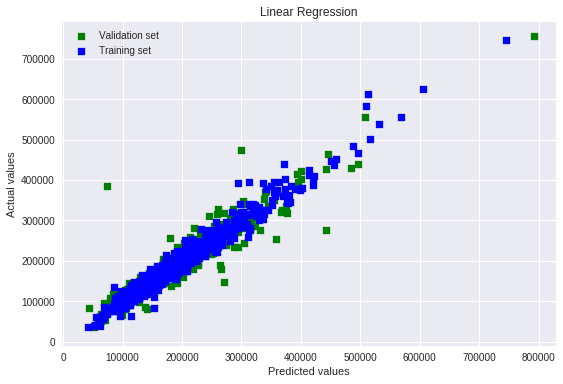

In [19]:
# make predictions with  linear regression model and plot values
pred_val, pred_train, y_val, y_tr = fit_model(linRegr_clf, all_train, 'SalePrice', test_size=0.3)
plot_predictions(pred_val, pred_train, y_val, y_tr, plot_title='Linear Regression')

In [20]:
#check the score now on the test set X_test. We fit the model on the whole training set 
linRegr_clf = linRegr_clf.fit(X_train, y_train)
test_pred = np.expm1(linRegr_clf.predict(X_test))

In [21]:
#create a .csv file to submit solution
def submit(df, title='Solution.csv'):
    df.to_csv(title, index=False)

In [22]:
solution=pd.DataFrame({"Id":house_test.Id, "SalePrice":test_pred})
solution.head()

,Id,SalePrice
0,1461,121652.528
1,1462,167188.215
2,1463,183049.966
3,1464,203650.254
4,1465,193785.334


In [23]:
#create solution file
#submit(solution, '../Solutions/House_prices/Linear_regr_solution.csv')

### Ridge Regression

We now introduce regularization using Ridge Regression. 

In [24]:
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import cross_val_score

In order to avoid overfit we set the alpha parameters. This will be multiplied by the square norm of the weights vector.
The higher the value the less prone will be our model to overfitting.
However, if this parameter is set too big, we risk to generalize badly. 
So we need to tune the parameter trying the model with different values and choose the best one.

In [25]:
#trying different values of parameter alpha
alphas = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]

In [26]:
#we use cross_val_score to find the best alpha
cv_ridge = [cross_val_score(Ridge(alpha = alpha), X_train, y_train, cv=5).mean() 
            for alpha in alphas]

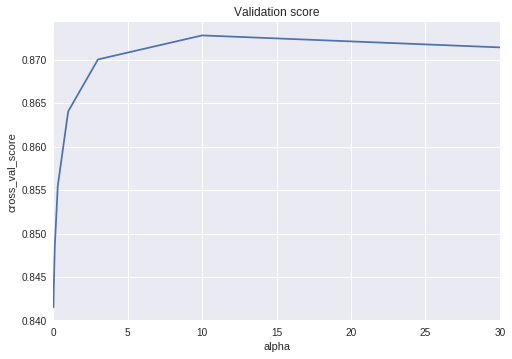

In [27]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation score")
plt.xlabel("alpha")
plt.ylabel("cross_val_score");

In [28]:
#we choose 10 as value with the best score now let's try it on the test set
ridge_model = Ridge(alpha=10)
evaluate(ridge_model, all_train)

Root mean squared error: 0.13
Variance score: 0.89
Root mean squared error: 0.14
Variance score: 0.88
Root mean squared error: 0.14
Variance score: 0.88
Root mean squared error: 0.15
Variance score: 0.87
Root mean squared error: 0.13
Variance score: 0.90
Root mean squared error: 0.20
Variance score: 0.73
Root mean squared error: 0.19
Variance score: 0.76
Root mean squared error: 0.13
Variance score: 0.90
Root mean squared error: 0.14
Variance score: 0.88
Root mean squared error: 0.20
Variance score: 0.77

Average score: 0.85
Average rmse: 0.15


Root mean squared error: 0.12
Variance score on validation set: 0.92
Variance score on training set: 0.91


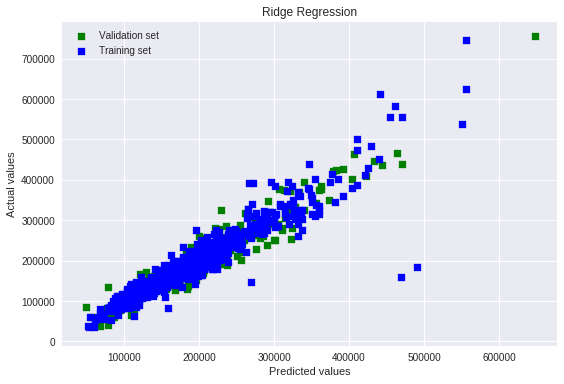

In [30]:
#we plot our predictions as before
# make predictions with  linear regression model and plot values
pred_val, pred_train, y_val, y_tr = fit_model(ridge_model, all_train, 'SalePrice', test_size=0.3)
plot_predictions(pred_val, pred_train, y_val, y_tr, plot_title='Ridge Regression')

In [ ]:
#ok now it's time to submit a solution
ridge_model.fit(X_train, y_train)
ridge_pred = np.expm1(ridge_model.predict(X_test))


In [ ]:
solution=pd.DataFrame({"Id":house_test.Id, "SalePrice":ridge_pred})
solution.head()

In [ ]:
#submit(solution, '../Solutions/House_prices/Ridge_regr_solution.csv')